In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
import pandas as pd
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord

In [132]:
# Failed attempt to crossmatch the sample with datasets for initial guess
# Using my current estimates instead
# For stars without calibrated pars (using Anna's relation)
# estimate based on summary plots.

# star_hdus = fits.open('../../Fa2020_MW_substructure/data/dr6_v2_stellar_LRS.fits')
# arr_l6 = star_hdus[1].data
# star_hdus.close()

# df_all = pd.read_csv('../data/SkyMapper_MIKE_Observations_w_RV.csv')
# N_star = len(df_all)
# N_sample = 1e4

# # Compute the galactic coordinate and put them in the df
# c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
# # Get initial guess of stellar parameters and their uncertainties from SSPP
# catalog = SkyCoord(ra=arr_l6['ra']*u.degree, dec=arr_l6['dec']*u.degree)
# idx, d2d, d3d = c_input.match_to_catalog_3d(catalog)
# # Add the sdss dr16 redshifts to the data frame
# temp_ind = (d2d < 3*u.arcsec)

# ind_matched = np.arange(N_star)[temp_ind]

In [2]:
# Export a list of just ra and dec for later crossmatching
# df_all.to_csv('../data/rpa4_ra_dec_for_query.csv', columns=['RA','DEC'],index=False)
# Export a list of just logg, feh, and teff for finding BC_V
df_all = pd.read_csv('../data/rpa4_w_RV.csv')
df_par_ini = df_all.loc[:,['logg_ini','feh_ini','teff_ini']]
# Create duplicates of the stellar par initial guess with e_teff = 200 and e_logg = 0.3
par_ini_dup_name = ['teff_ini','logg_ini']
par_ini_dup_err = [200,0.3]

df_par_dup1 = df_par_ini.copy()
df_par_dup1[par_ini_dup_name[0]] = df_par_dup1[par_ini_dup_name[0]] + par_ini_dup_err[0]
df_par_dup1[par_ini_dup_name[1]] = df_par_dup1[par_ini_dup_name[1]] + par_ini_dup_err[1]

df_par_dup2 = df_par_ini.copy()
df_par_dup2[par_ini_dup_name[0]] = df_par_dup2[par_ini_dup_name[0]] - par_ini_dup_err[0]
df_par_dup2[par_ini_dup_name[1]] = df_par_dup2[par_ini_dup_name[1]] - par_ini_dup_err[1]

df_par_ini_for_bcv = pd.concat([df_par_ini,df_par_dup1,df_par_dup2])

# Compute the galactic coordinate and put them in the df
c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
c_input_gal = c_input.galactic
df_all['l'], df_all['b'] = c_input_gal.l, c_input_gal.b

In [8]:
# Since BC codes only handles one E(B-V) at a time
# Manualy loop through all stars to get their BCV and e_BCV

# put in BJ 2021's distance measurement here
df_bj21 = pd.read_csv('../data/rpa4_BJ21_dist.csv',skip_blank_lines=True,comment='#',sep=';')

# Get E(B-V) and their uncertainties from https://irsa.ipac.caltech.edu/applications/DUST/
# by uploading a table
# Get 3D values from dustmap package
df_EBV = pd.read_csv('../data/rpa4_EBV.csv',comment='#',delim_whitespace=True)
df_EBV3D = pd.read_csv('../data/rpa4_EBV3D.csv')

# Apply reddening correction for stars based on their distances and galactic latitude
h = 125 # in pc
for i in range(len(df_all)):
    dist = df_bj21['rpgeo'][i]
    if dist < 70.0:
        print('Use E(B-V) = 0 for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')
    else:
        if np.isnan(df_EBV3D.loc[i,'EBV3Dweb']) == True:
            # Use SF11 mod
            b_tmp = df_all.loc[i,'b']
            ebv_mod = df_EBV.loc[i,'|E_B_V_SandF']*(1-np.exp(-np.abs(dist*np.sin(b_tmp*np.pi/180)/h)))
            print('Use E(B-V)_mod =',ebv_mod, 'for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')
        else:
            # Use 3D value
            ebv_3d = df_EBV3D.loc[i,'EBV3Dweb']
            print('Use E(B-V)_3D =',ebv_3d, 'for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')

Use E(B-V)_3D = 0.01696149 for RPA1319 at i= 0 with d = 4187.43115 kpc
Use E(B-V)_3D = 0.06265647 for RPA2219 at i= 1 with d = 2427.03174 kpc


In [10]:
i = 1

df_par_ini_for_bcv.loc[[i],['logg_ini','feh_ini','teff_ini']].to_csv('../data/BC_for_stellar_param/BCcodes/input.sample',header=False,index=False,sep=' ',float_format='%.2f')

In [7]:
V_J_coeff = np.array([0.4669,0.3849,-0.0350,-0.0140,0.0225,0.0011])
V_H_coeff = np.array([0.5251,0.2553,-0.0119,-0.0187,0.0410,0.0025])
V_K_coeff = np.array([0.5057,0.2600,-0.0146,-0.0131,0.0288,0.0016])
J_K_coeff = np.array([0.6393,0.6104,0.0920,-0.0330,0.0291,0.0020])
C10scatter = np.array([42,33,25,132])

color_up_bound = np.array([2.44,3.01,3.15,0.80])
color_lo_bound = np.array([0.61,0.67,0.78,0.07])

def c10_color_feh_teff_fundamental_logg(feh,e_feh,bcv,e_bcv,df_input,ian_eq=False):
    # Iterate thorugh each star in the list 
    N_star=len(df_input)
    
    teff_w_mean_arr = np.zeros(N_star)
    teff_w_std_arr = np.zeros(N_star)
    teff_V_J_mean_arr, teff_V_J_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_V_H_mean_arr, teff_V_H_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_V_K_mean_arr, teff_V_K_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_J_K_mean_arr, teff_J_K_std_arr = np.zeros(N_star), np.zeros(N_star)
    logg_med_arr = np.zeros(N_star)
    logg_std_arr = np.zeros(N_star)
    
    # Get the mass resampling, which is the same for all stars
    # in unit of solar mass
    M_sample = np.random.normal(0.8,0.08,N_sample)
    
    for i in range(N_star):
        # Get the distance sample directly using photogeometric values from BJ 2021
        # In unit of pc
        dist_mean, dist_std = pd.to_numeric(df_input.loc[i,'dist'],errors='coerce'), pd.to_numeric(df_input.loc[i,'e_dist'],errors='coerce')
        dist_sample = np.random.normal(dist_mean, dist_std, N_sample)
        
        # Get the reduced E(B-V) resampled
        ebv_mean, eebv_std = df_input.loc[i,'EBV'], df_input.loc[i,'e_EBV']
        ebvinf_mean = df_input.loc[i,'EBVinf']
        
        # Modify the E(B-V) according to the RPA guideline
        h = 125
        if np.isnan(ebv_mean) == True:
            # If 3D E(B-V) not available, use the previous corrections on SF11
            b_tmp = df_input.loc[i,'b']
            if ian_eq == False:
                ebv_sample = np.random.normal(ebvinf_mean,eebv_std,N_sample)
                ebv_sample = ebv_sample*(1-np.exp(-np.abs(dist_sample*np.sin(b_tmp*np.pi/180)/h)))
            else:
                ebv_mean_mod = ebvinf_mean*(1-np.exp(-np.abs(dist_sample*np.sin(b_tmp*np.pi/180)/h)))
                ebv_sample = ebv_mean_mod + np.random.normal(0,eebv_std,N_sample)
            df_input.loc[i,'EBVinf_mod_flg'] = 1
        else:
            ebv_sample = np.random.normal(ebv_mean,eebv_std,N_sample)
            
        
        # Remove any negative E(B-V) from resampling
        for j in range(N_sample):
            ebv_sample[j] = max(ebv_sample[j],0.0)
        
        # Stars within 70 pc has zero reddening
        if np.median(dist_sample) < 70.:
            ebv_sample = ebv_sample*0.0
            df_input.loc[i,'EBVzero_mod_flg'] = 1
            
        # Record the final adopted mean E(B-V)
        df_input.loc[i,'EBVadopt'] = np.mean(ebv_sample)
        
        # Get the magnitudes and their uncertainties
        mag_mean = df_input.loc[i,mag_name].astype('float').values
        mag_err = df_input.loc[i,e_mag_name].astype('float').values
        
        # Replace negative magnitude errors with nan
        for j in range(len(mag_err)):
            if mag_err[j] < 0.0:
                mag_mean[j], mag_err[j] = np.nan, np.nan
        
        # Resample 10^4 times assuming normal distribution
        B_sample = np.random.normal(mag_mean[0],mag_err[0],N_sample)
        V_sample = np.random.normal(mag_mean[1],mag_err[1],N_sample)
        J_sample = np.random.normal(mag_mean[2],mag_err[2],N_sample)
        H_sample = np.random.normal(mag_mean[3],mag_err[3],N_sample)
        K_sample = np.random.normal(mag_mean[4],mag_err[4],N_sample)
        
        # Put them together and create temp list for later use
        mag_sample = [B_sample,V_sample,J_sample,H_sample,K_sample]
        magdered_sample = [np.zeros(N_sample)]*len(R_lbd)
        
        # Get the dereddened magnitudes with 0.01 error assumed in R_lbda
        # Also store the resampled R_lbd for later use
        R_lbd_sample_list = []
        for j in range(len(R_lbd)):
            R_lbd_sample = np.random.normal(R_lbd[j],0.01,N_sample)
            R_lbd_sample_list.append(R_lbd_sample)
            A_lbd_sample = R_lbd_sample*ebv_sample
            magdered_sample[j] = mag_sample[j] - A_lbd_sample
        
        magdered_mean = [np.mean(x) for x in magdered_sample]
        
        # Raise an flag if the mean color is outside of applicable range
        if magdered_mean[1]-magdered_mean[2] < color_lo_bound[0] or magdered_mean[1]-magdered_mean[2] > color_up_bound[0] \
        or magdered_mean[1]-magdered_mean[3] < color_lo_bound[1] or magdered_mean[1]-magdered_mean[3] > color_up_bound[1] \
        or magdered_mean[1]-magdered_mean[4] < color_lo_bound[2] or magdered_mean[1]-magdered_mean[4] > color_up_bound[2] \
        or magdered_mean[2]-magdered_mean[4] < color_lo_bound[3] or magdered_mean[2]-magdered_mean[4] > color_up_bound[3]:
            print('Star index:',i,'has mean color outside of the applicable range!')
        
        # Get the [Fe/H] and its uncertainty
        feh_mean = feh[i]
        feh_err = e_feh[i]
        feh_sample = np.random.normal(feh_mean,feh_err,N_sample)
        
        # Get the colors
        if ian_eq == False:
            V_J_sample = magdered_sample[1]-magdered_sample[2]
            V_H_sample = magdered_sample[1]-magdered_sample[3]
            V_K_sample = magdered_sample[1]-magdered_sample[4]
            J_K_sample = magdered_sample[2]-magdered_sample[4]
        else:
            # Get the colors according to Ian's function
            V_J_sample = V_sample - J_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[2]))
            V_H_sample = V_sample - H_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[3]))
            V_K_sample = V_sample - K_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[4]))
            J_K_sample = J_sample - K_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[2]-R_lbd_sample_list[4]))
        
        
        
        # Use the relation to get a sample of Teff
        teff_V_J_sample = 5040/(V_J_coeff[0] + V_J_coeff[1]*V_J_sample + V_J_coeff[2]*V_J_sample**2 + V_J_coeff[3]*V_J_sample*feh_sample +\
                          V_J_coeff[4]*feh_sample + V_J_coeff[5]*feh_sample**2)
        teff_V_H_sample = 5040/(V_H_coeff[0] + V_H_coeff[1]*V_H_sample + V_H_coeff[2]*V_H_sample**2 + V_H_coeff[3]*V_H_sample*feh_sample +\
                          V_H_coeff[4]*feh_sample + V_H_coeff[5]*feh_sample**2)
        teff_V_K_sample = 5040/(V_K_coeff[0] + V_K_coeff[1]*V_K_sample + V_K_coeff[2]*V_K_sample**2 + V_K_coeff[3]*V_K_sample*feh_sample +\
                          V_K_coeff[4]*feh_sample + V_K_coeff[5]*feh_sample**2)
        teff_J_K_sample = 5040/(J_K_coeff[0] + J_K_coeff[1]*J_K_sample + J_K_coeff[2]*J_K_sample**2 + J_K_coeff[3]*J_K_sample*feh_sample +\
                          J_K_coeff[4]*feh_sample + J_K_coeff[5]*feh_sample**2)
        
        # Plot the distribution of the colors and the resulting teff for debugging
#         if i == 0:
#             plt.hist(V_J_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('V-J')
#             plt.show()
            
#             plt.hist(teff_V_J_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('Teff V-J')
#             plt.show()
            
#             plt.hist(V_H_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('V-H')
#             plt.show()
            
#             plt.hist(teff_V_H_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('Teff V-H')
#             plt.show()
            
#             plt.hist(V_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('V-K')
#             plt.show()
            
#             plt.hist(teff_V_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('Teff V-K')
#             plt.show()
            
#             plt.hist(J_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('J-K')
#             plt.show()
            
#             plt.hist(teff_J_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
#             plt.title('Teff J-K')
#             plt.show()
        
        
        # Find the mean and standard deviation
        teff_V_J_mean, teff_V_J_std = np.mean(teff_V_J_sample), np.std(teff_V_J_sample)
        teff_V_H_mean, teff_V_H_std = np.mean(teff_V_H_sample), np.std(teff_V_H_sample)
        teff_V_K_mean, teff_V_K_std = np.mean(teff_V_K_sample), np.std(teff_V_K_sample)
        teff_J_K_mean, teff_J_K_std = np.mean(teff_J_K_sample), np.std(teff_J_K_sample)
        
        # Compute weighted average and weighted std
        # Incorporate the intrinsic scatter of the relation
        teff_mean_arr = np.array([teff_V_J_mean,teff_V_H_mean,teff_V_K_mean,teff_J_K_mean])
        teff_std_arr = np.array([teff_V_J_std,teff_V_H_std,teff_V_K_std,teff_J_K_std])
        teff_std_arr_p_sca = np.sqrt(teff_std_arr**2+C10scatter**2)
        weight = 1/teff_std_arr_p_sca**2
        teff_w_mean = np.sum(weight*teff_mean_arr)/np.sum(weight)
        teff_w_std = np.sqrt(np.sum(weight*(teff_mean_arr-teff_w_mean)**2)/np.sum(weight)*4/3)
        
        
        teff_w_mean_arr[i], teff_w_std_arr[i] = teff_w_mean, teff_w_std
        teff_V_J_mean_arr[i], teff_V_J_std_arr[i] = teff_V_J_mean, teff_V_J_std
        teff_V_H_mean_arr[i], teff_V_H_std_arr[i] = teff_V_H_mean, teff_V_H_std
        teff_V_K_mean_arr[i], teff_V_K_std_arr[i] = teff_V_K_mean, teff_V_K_std
        teff_J_K_mean_arr[i], teff_J_K_std_arr[i] = teff_J_K_mean, teff_J_K_std
        
        # Now start to calculate log g
        # Get a new Teff resample with the added fudge factor
        # Add a fudge factor to account for systematics
        # (This might introduce some inconsistency...)
        teff_fudge = 250
        teff_w_std_f = np.sqrt(teff_w_std**2 + teff_fudge**2)
        teff_sample = np.random.normal(teff_w_mean, teff_w_std_f, N_sample)
        
        # Get the BC_V sample
        bcv_mean, bcv_std = bcv[i], e_bcv[i]
        bcv_sample = np.random.normal(bcv_mean, bcv_std, N_sample)
        
        # Calculate log g
        
        logg_sample = 4*np.log10(teff_sample) + np.log10(M_sample) - 10.61 + \
                      0.4*(bcv_sample + V_sample - 5*np.log10(dist_sample) + \
                           5 - 3.1*ebv_sample - 4.75)
        if i == 8: # For debugging
            print(V_J_sample[0],V_H_sample[0],V_K_sample[0],J_K_sample[0])
#             print(teff_sample[0],M_sample[0],bcv_sample[0],V_sample[0],dist_sample[0],ebv_sample[0])
        
        logg_med_arr[i], logg_std_arr[i] = np.nanmedian(logg_sample), np.nanstd(logg_sample)
    
    
    return teff_V_J_mean_arr, teff_V_J_std_arr, teff_V_H_mean_arr, teff_V_H_std_arr,\
           teff_V_K_mean_arr, teff_V_K_std_arr, teff_J_K_mean_arr, teff_J_K_std_arr,\
           teff_w_mean_arr, teff_w_std_arr, logg_med_arr, logg_std_arr

In [12]:
# import the 88 stars with thier position in the sky and radial velicities(don't need this one really, but well...)
df_all = pd.read_csv('../data/rpa4_w_RV.csv')
N_star = len(df_all)
N_sample = int(1e4)

# Compute the galactic coordinate and put them in the df
c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
c_input_gal = c_input.galactic
df_all['l'], df_all['b'] = c_input_gal.l, c_input_gal.b

# put in BJ 2021's distance measurement here
df_bj21 = pd.read_csv('../data/rpa4_BJ21_dist.csv',skip_blank_lines=True,comment='#',sep=';')
df_all['dist'], df_all['e_dist'] = df_bj21['rpgeo'], (df_bj21['B_rpgeo']-df_bj21['b_rpgeo'])/2

# Crossmatch the sample with 2MASS and APASS/Tycho-2
# to get photometry and their uncertainties 
# Minimum uncertainties as described in Ian's document
df_BVJHK = pd.read_csv('../data/rpa4_BVJHK.csv',comment='#',sep=';')

# Take away duplicates in APASS that has no corresponding 2MASS
# Checked that the duplicates are surely the same object
df_BVJHK = df_BVJHK.drop(np.where((df_BVJHK['2MASS'].values) == '                 ')[0]).reset_index()

# Take the BVJHK magnitues and uncertainties into the main dataframe
df_all['Bmag'],df_all['e_Bmag'] = df_BVJHK['Bmag_A'].astype('float'), df_BVJHK['e_Bmag_A'].astype('float')
df_all['Vmag'],df_all['e_Vmag'] = df_BVJHK['Vmag_A'].astype('float'), df_BVJHK['e_Vmag_A'].astype('float')
df_all['Jmag'],df_all['e_Jmag'] = df_BVJHK['Jmag'].astype('float'), df_BVJHK['e_Jmag'].astype('float')
df_all['Hmag'],df_all['e_Hmag'] = df_BVJHK['Hmag'].astype('float'), df_BVJHK['e_Hmag'].astype('float')
df_all['Kmag'],df_all['e_Kmag'] = df_BVJHK['Kmag'].astype('float'), df_BVJHK['e_Kmag'].astype('float')
df_all['BVmag_source'] = ['APASS']*N_star

# Replace APASS BV with Tycho-2 BV if V < 9.0 or APASS value is absent
for i in range(N_star):
    if df_all.loc[i,'Vmag'] < 9.0 or np.isnan(df_all.loc[i,'Vmag']) == True:
        df_all.loc[i,'Bmag'] = pd.to_numeric(df_BVJHK.loc[i,'BTmag'],errors='coerce')
        df_all.loc[i,'e_Bmag'] = pd.to_numeric(df_BVJHK.loc[i,'e_BTmag'],errors='coerce')
        df_all.loc[i,'Vmag'] = pd.to_numeric(df_BVJHK.loc[i,'VTmag'],errors='coerce')
        df_all.loc[i,'e_Vmag'] = pd.to_numeric(df_BVJHK.loc[i,'e_VTmag'],errors='coerce')
        df_all.loc[i,'BVmag_source'] = 'Tycho-2'

# Set minimum errors for diff sources
e_mag_min_A = [0.0328,0.0323,0.02,0.02,0.02]
e_mag_min_T = [0.0294,0.0634,0.02,0.02,0.02]
e_mag_name = ['e_Bmag','e_Vmag','e_Jmag','e_Hmag','e_Kmag']
        
# Enforce the minimum and maximum uncertainty
for i in range(N_star):
    if df_all.loc[i,'BVmag_source'] == 'APASS':
        min_temp = e_mag_min_A
    else:
        min_temp = e_mag_min_T
    
    for j in range(len(e_mag_name)):
        # Enforce overall maximum bound
        if df_all.loc[i,e_mag_name[j]] > 0.25:
            df_all.loc[i,e_mag_name[j]] = 0.25
        # Enforce specific minimum bounds
        if df_all.loc[i,e_mag_name[j]] < min_temp[j]:
            df_all.loc[i,e_mag_name[j]] = min_temp[j]

            
# Get E(B-V) and their uncertainties from https://irsa.ipac.caltech.edu/applications/DUST/
# by uploading a table
df_EBV = pd.read_csv('../data/rpa4_EBV.csv',comment='#',delim_whitespace=True)
df_EBV3D = pd.read_csv('../data/rpa4_EBV3D.csv')

# Get E(B-V)_mod using Gaia distances and uncertainties calculated by BJ 2021
# This modification is a bit debatable since a significant portion of my sample has bad parallax uncertainty
# Modify the E(B-V) according to RPA
df_all['EBV'] = df_EBV3D['EBV3Dweb']
df_all['EBVinf'], df_all['e_EBV'] = df_EBV['|E_B_V_SandF'], df_EBV['|stdev_E_B_V_SandF']
df_all['EBVinf_mod_flg'] = [0]*N_star
df_all['EBVzero_mod_flg'] = [0]*N_star
df_all['EBVadopt'] = [0]*N_star

h = 125 # scale height of the reddening layer in unit of pc


# Use R_lambda from McCall Table 1 to get A_lambda and deredden the photometry magnitudes
R_lbd = [4.070,3.070,0.819,0.519,0.350]
A_lbd_name = ['A_B','A_V','A_J','A_H','A_K']
mag_name = ['Bmag','Vmag','Jmag','Hmag','Kmag']
# mag_dered_name = ['Bmag_dered','Vmag_dered','Jmag_dered','Hmag_dered','Kmag_dered']


# Feed the numbers into the relations (which comes with its own scatter) 
# and resample based on uncertainties 
# to get Teffs with errors from [Fe/H] and color and their errors 
# Error for [Fe/H] set to constant 0.15
# Get a Teff from weighted averages
df_all['teff_V_J_loop0'], df_all['e_teff_V_J_loop0'], df_all['teff_V_H_loop0'], df_all['e_teff_V_H_loop0'], \
df_all['teff_V_K_loop0'], df_all['e_teff_V_K_loop0'], df_all['teff_J_K_loop0'], df_all['e_teff_J_K_loop0'], \
df_all['teff_loop0'], df_all['e_teff_loop0'], df_all['logg_loop0'], df_all['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_all['feh_ini'].values,np.ones(N_star)*0.15,df_all['BCV_ini'].values,df_all['e_BCV_ini'].values,df_all)


# Use this Teff and fundamental relation to get log g
# the uncertainties included when available 
# Figure out the error on BC_V 
# Test how much BC_V changes when E(B-V) fluctuates in its error
# Using the a rough estimate for e_BCV: (BCV[teff+200,logg+0.3, E(B-V)]-BCV[teff-200,logg-0.3], E(B-V))/2
# The resulting error in BCV appears to only depend on teff and logg and their uncertainties,
# not so much on changes in E(B-V), which justifies the lack of varying E(B-V) for measuring error in E(B-V).
# For now, I would assume that BCV and e_BCV doesn't change from iteration to iteration, so long
# as teff and logg are not varying hugely between iteration.
# The process of getting BC_V is very painful at the moment...


# Use these Teff and logg with their uncertainties
# into SHMR and get [Fe/H] and its uncertainty (using script by Alex)
# Write out the result after this first loop (loop0)
df_all.to_csv('../data/rpa4_loop0.csv',index=False)

# Repeat the process with the new [Fe/H]

In [13]:
# Read in the new [Fe/H] values
df_all = pd.read_csv('../data/rpa4_loop0_w_feh.csv')

df_par_loop0 = df_all.loc[:,['logg_loop0','feh_loop0','teff_loop0']]
# Create duplicates of the stellar par initial guess with e_teff = 200 and e_logg = 0.3
par_ini_dup_name = ['teff_loop0','logg_loop0']
par_ini_dup_err = ['e_teff_loop0','e_logg_loop0']

df_par_dup1 = df_par_loop0.copy()
df_par_dup1[par_ini_dup_name[0]] = df_par_dup1[par_ini_dup_name[0]] + df_all[par_ini_dup_err[0]]
df_par_dup1[par_ini_dup_name[1]] = df_par_dup1[par_ini_dup_name[1]] + df_all[par_ini_dup_err[1]]

df_par_dup2 = df_par_loop0.copy()
df_par_dup2[par_ini_dup_name[0]] = df_par_dup2[par_ini_dup_name[0]] - df_all[par_ini_dup_err[0]]
df_par_dup2[par_ini_dup_name[1]] = df_par_dup2[par_ini_dup_name[1]] - df_all[par_ini_dup_err[1]]

df_par_loop0_for_bcv = pd.concat([df_par_loop0,df_par_dup1,df_par_dup2])

# Since BC codes only handles one E(B-V) at a time
# Manualy loop through all stars to get their BCV and e_BCV

In [14]:
# Apply reddening correction for stars based on their distances and galactic latitude
h = 125 # in pc
for i in range(len(df_all)):
    dist = df_bj21['rpgeo'][i]
    if dist < 70.0:
        print('Use E(B-V) = 0 for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')
    else:
        if np.isnan(df_EBV3D.loc[i,'EBV3Dweb']) == True:
            # Use SF11 mod
            b_tmp = df_all.loc[i,'b']
            ebv_mod = df_EBV.loc[i,'|E_B_V_SandF']*(1-np.exp(-np.abs(dist*np.sin(b_tmp*np.pi/180)/h)))
            print('Use E(B-V)_mod =',ebv_mod, 'for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')
        else:
            # Use 3D value
            ebv_3d = df_EBV3D.loc[i,'EBV3Dweb']
            print('Use E(B-V)_3D =',ebv_3d, 'for', df_all.loc[i,'Name'],'at i=',i,'with d =',dist,'kpc')


Use E(B-V)_3D = 0.01696149 for RPA1319 at i= 0 with d = 4187.43115 kpc
Use E(B-V)_3D = 0.06265647 for RPA2219 at i= 1 with d = 2427.03174 kpc


In [16]:
i = 1
df_par_loop0_for_bcv.loc[[i],['logg_loop0','feh_loop0','teff_loop0']].to_csv('../data/BC_for_stellar_param/BCcodes/input.sample',header=False,index=False,sep=' ',float_format='%.2f')

In [17]:
# Read in the new [Fe/H] values
df_all = pd.read_csv('../data/rpa4_loop0_w_feh.csv')

# Feed the numbers into the relations (which comes with its own scatter) 
# and resample based on uncertainties 
# to get Teffs with errors from [Fe/H] and color and their errors 
# Error for [Fe/H] set to constant 0.15
# Get a Teff from weighted averages
df_all['teff_V_J_loop1'], df_all['e_teff_V_J_loop1'], df_all['teff_V_H_loop1'], df_all['e_teff_V_H_loop1'], \
df_all['teff_V_K_loop1'], df_all['e_teff_V_K_loop1'], df_all['teff_J_K_loop1'], df_all['e_teff_J_K_loop1'], \
df_all['teff_loop1'], df_all['e_teff_loop1'], df_all['logg_loop1'], df_all['e_logg_loop1'] \
= c10_color_feh_teff_fundamental_logg(df_all['feh_loop0'].values,np.ones(N_star)*0.15,df_all['BCV_loop0'].values,df_all['e_BCV_loop0'].values,df_all)

# Write out the result after this second loop (loop1)
df_all.to_csv('../data/rpa4_loop1.csv',index=False)

In [18]:
df_bj21

,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag
0,3636133400286350976,199.945846,-4.386206,4216.35791,3847.98975,4666.08838,4187.43115,3872.11450,4679.99072,10033
1,6626606295405710848,334.784807,-23.563061,2406.14844,2324.28638,2504.76660,2427.03174,2314.10669,2540.38623,10033


In [234]:
mwtd_ind = [24, 25, 29, 34, 36, 40, 41, 69, 72, 73, 75]
print(df_all['Name'].values[mwtd_ind])

['SMSS1_09' 'SMSS1_12' 'SMSS1_18' 'SMSS1_29' 'SMSS1_33' 'SMSS338'
 'SMSS343' 'SMSS697' 'SMSS709' 'SMSS710' 'SMSS712']


In [235]:
print((df_all['teff_loop0'].values-df_all['teff_ini'].values)[mwtd_ind])

[252.46898328 -58.39093287 203.44605994   0.46531856  52.98741359
  32.77071785 -65.67468183 237.11257673 190.66334647 196.60573443
 220.65548423]


In [236]:
print((df_all['teff_loop1'].values-df_all['teff_loop0'].values)[mwtd_ind])

[ 5.14904006 -3.17592246  4.77162708  0.1707423   1.86116227 -1.194899
 -4.27016271  6.40509393  4.73572019  8.04738531  7.6999334 ]


In [237]:
print((df_all['logg_loop0'].values-df_all['logg_ini'].values)[mwtd_ind])

[0.3230901  0.44167714 0.42654624 0.18743025 0.46560243 0.42199057
 0.22714992 0.87108517 0.07183406 0.18677273 0.69615079]


In [238]:
print((df_all['logg_loop1'].values-df_all['logg_loop0'].values)[mwtd_ind])

[ 0.02992367 -0.00867547  0.02124479 -0.00071391  0.0182623   0.02492373
 -0.01081364  0.03852548  0.03170361  0.03138491  0.0210171 ]


In [239]:
print((df_all['teff_loop1'].values)[mwtd_ind])
print((df_all['logg_loop1'].values)[mwtd_ind])

[5229.61802334 4838.43314467 5252.21768701 5152.63606087 4756.84857586
 4571.57581885 4848.05515546 5053.51767066 4942.39906666 5014.65311974
 5191.35541763]
[2.20301377 1.83300167 2.69779103 2.68671634 1.48386473 0.9969143
 2.01633629 1.75961065 1.30353767 1.76815764 2.21716788]


In [425]:
df_all.loc[34,'feh_ini']

1.77

In [451]:
print(df_all.columns)
print(df_ian.columns)

Index(['Name', 'RA', 'DEC', 'Disk/Halo membership', 'Obs.date', 'rv',
       'helio_correction', 'bary_correction', 'rv_uncertainty', 'teff_ini',
       'logg_ini', 'feh_ini', 'ini_v5flg', 'BCV_ini', 'e_BCV_ini', 'l', 'b',
       'dist', 'e_dist', 'plx', 'e_plx', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag',
       'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'BVmag_source',
       'EBV', 'e_EBV', 'EBV_mod_flg', 'teff_V_J_loop0', 'e_teff_V_J_loop0',
       'teff_V_H_loop0', 'e_teff_V_H_loop0', 'teff_V_K_loop0',
       'e_teff_V_K_loop0', 'teff_J_K_loop0', 'e_teff_J_K_loop0', 'teff_loop0',
       'e_teff_loop0', 'logg_loop0', 'e_logg_loop0', 'feh_loop0', 'BCV_loop0',
       'e_BCV_loop0', 'teff_V_J_loop1', 'e_teff_V_J_loop1', 'teff_V_H_loop1',
       'e_teff_V_H_loop1', 'teff_V_K_loop1', 'e_teff_V_K_loop1',
       'teff_J_K_loop1', 'e_teff_J_K_loop1', 'teff_loop1', 'e_teff_loop1',
       'logg_loop1', 'e_logg_loop1'],
      dtype='object')
Index(['#NAME', 'RA', 'DEC', 'RA_DEG', 'DEC_DEG'

In [136]:
# Cross check how my code work with Ian's sample input RPA stars
# (I could also adapt my stars to work with Ian's code, but the formatting
# seems to be a lot more work, and I assume Ian's sample is more well-distributed
# in the par space.)
N_sample = int(1e4)


df_ian = pd.read_csv('teff_logg_updated042121/rpa.photo',delim_whitespace=True,skiprows=[1])
df_ian['e_dist'] = (df_ian['UDISTBJ']-df_ian['LDISTBJ'])/2
N_star = len(df_ian)

# Rename the columns and make some copies to make it work with my code
df_ian_myeq = df_ian.rename(columns={'LONGITUDE':'l','LATITUDE':'b','JMAG':'Jmag','KMAG':'Kmag','HMAG':'Hmag',
                       'EJMAG':'e_Jmag','EKMAG':'e_Kmag','EHMAG':'e_Hmag',
                       'B_FIN':'Bmag','V_FIN':'Vmag','EB_FIN':'e_Bmag','EV_FIN':'e_Vmag',
                       'PLX':'plx','EPLX':'e_plx','EBVA':'EBVinf','EEBVA':'e_EBV','EBV3DD':'EBV',
                       'BCV':'BCV_ini','EBCV':'e_BCV_ini',
                       'TEFF':'teff_ini','LOGG':'logg_ini','FEH':'feh_ini','DISTBJ':'dist'})

df_ian_ianeq = df_ian.rename(columns={'LONGITUDE':'l','LATITUDE':'b','JMAG':'Jmag','KMAG':'Kmag','HMAG':'Hmag',
                       'EJMAG':'e_Jmag','EKMAG':'e_Kmag','EHMAG':'e_Hmag',
                       'B_FIN':'Bmag','V_FIN':'Vmag','EB_FIN':'e_Bmag','EV_FIN':'e_Vmag',
                       'PLX':'plx','EPLX':'e_plx','EBVA':'EBVinf','EEBVA':'e_EBV','EBV3DD':'EBV',
                       'BCV':'BCV_ini','EBCV':'e_BCV_ini',
                       'TEFF':'teff_ini','LOGG':'logg_ini','FEH':'feh_ini','DISTBJ':'dist'})

In [139]:
df_ian_myeq['teff_V_J_loop0'], df_ian_myeq['e_teff_V_J_loop0'], df_ian_myeq['teff_V_H_loop0'], df_ian_myeq['e_teff_V_H_loop0'], \
df_ian_myeq['teff_V_K_loop0'], df_ian_myeq['e_teff_V_K_loop0'], df_ian_myeq['teff_J_K_loop0'], df_ian_myeq['e_teff_J_K_loop0'], \
df_ian_myeq['teff_loop0'], df_ian_myeq['e_teff_loop0'], df_ian_myeq['logg_loop0'], df_ian_myeq['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_ian_myeq['feh_ini'].values,np.ones(N_star)*0.03,df_ian_myeq['BCV_ini'].values,df_ian_myeq['e_BCV_ini'].values,df_ian_myeq,ian_eq=False)

Star index: 8 has mean color outside of the applicable range!
2.429036222103935 3.2323573465730115 3.4049549573654483 0.9759187352615131
Star index: 33 has mean color outside of the applicable range!
Star index: 36 has mean color outside of the applicable range!
Star index: 39 has mean color outside of the applicable range!
Star index: 42 has mean color outside of the applicable range!


<ipython-input-138-523dcc8d213a>:204: RuntimeWarning: invalid value encountered in log10
  logg_sample = 4*np.log10(teff_sample) + np.log10(M_sample) - 10.61 + \


Star index: 66 has mean color outside of the applicable range!
Star index: 89 has mean color outside of the applicable range!
Star index: 90 has mean color outside of the applicable range!
Star index: 100 has mean color outside of the applicable range!
Star index: 101 has mean color outside of the applicable range!
Star index: 110 has mean color outside of the applicable range!
Star index: 111 has mean color outside of the applicable range!
Star index: 118 has mean color outside of the applicable range!
Star index: 120 has mean color outside of the applicable range!


In [124]:
print(df_ian_myeq['e_Hmag'].values)

[ 0.026  0.024  0.051  0.022  0.053  0.038  0.023  0.018  0.016  0.023
  0.033  0.023  0.021  0.023  0.021  0.023  0.022  0.026  0.024  0.023
  0.024  0.049  0.017  0.021  0.02   0.023  0.022  0.026  0.026  0.063
  0.024  0.025  0.044  0.364  0.024  0.02   0.035  0.04   0.022  0.02
  0.033  0.021  0.094  0.022  0.021  0.034  0.026  0.027  0.024  0.022
  0.047  0.027  0.022  0.023  0.024  0.023  0.016  0.022  0.024  0.051
  0.027  0.026  0.022  0.021  0.042  0.053 -9.999  0.021  0.047  0.053
  0.026  0.025  0.055  0.015  0.023  0.036  0.024  0.024  0.053  0.036
  0.022  0.029  0.025  0.024  0.024  0.031  0.031  0.024  0.024  0.038
  0.036  0.038  0.04   0.024  0.026  0.055  0.026  0.038  0.022  0.029
  0.038  0.21   0.033  0.022  0.026  0.018  0.02   0.029  0.02   0.024
  0.026  0.02   0.022  0.018  0.017  0.03   0.024  0.04   0.059  0.025
  0.042  0.049  0.024  0.033  0.024  0.022  0.022  0.049  0.034  0.026
  0.038  0.047  0.022  0.026  0.022  0.022  0.023  0.031  0.029  0.02
  0.029]

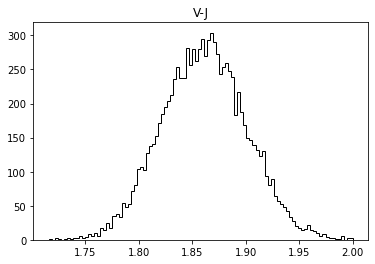

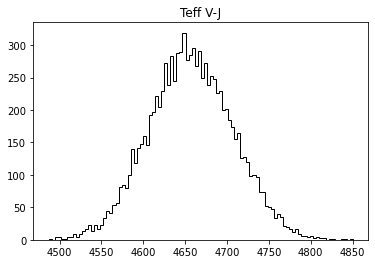

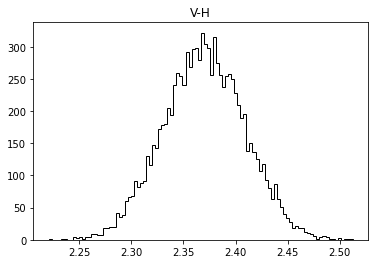

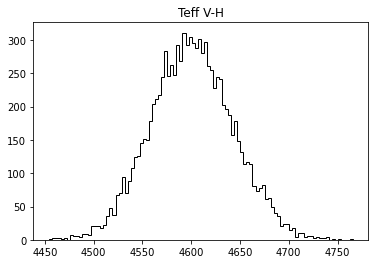

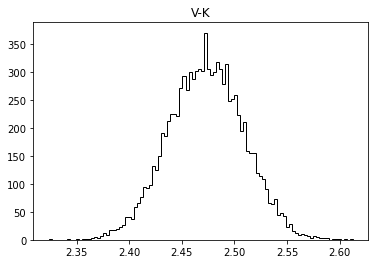

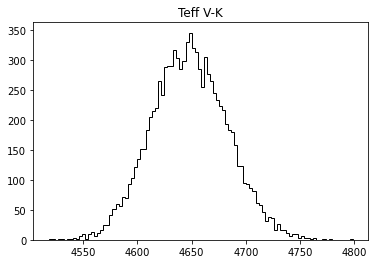

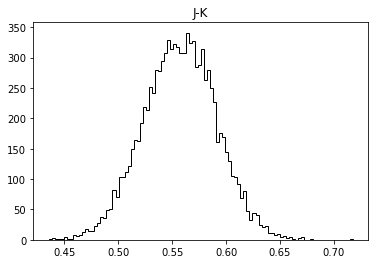

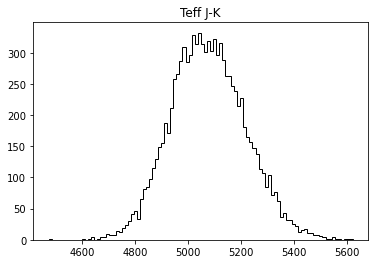

Star index: 8 has mean color outside of the applicable range!
Star index: 18 has mean color outside of the applicable range!


ValueError: scale < 0

In [118]:
df_ian_ianeq['teff_V_J_loop0'], df_ian_ianeq['e_teff_V_J_loop0'], df_ian_ianeq['teff_V_H_loop0'], df_ian_ianeq['e_teff_V_H_loop0'], \
df_ian_ianeq['teff_V_K_loop0'], df_ian_ianeq['e_teff_V_K_loop0'], df_ian_ianeq['teff_J_K_loop0'], df_ian_ianeq['e_teff_J_K_loop0'], \
df_ian_ianeq['teff_loop0'], df_ian_ianeq['e_teff_loop0'], df_ian_ianeq['logg_loop0'], df_ian_ianeq['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_ian_ianeq['feh_ini'].values,np.ones(N_star)*0.03,df_ian_ianeq['BCV_ini'].values,df_ian_ianeq['e_BCV_ini'].values,df_ian_ianeq,ian_eq=True)

In [140]:
df_ian_myeq.loc[:,['teff_V_J_loop0','e_teff_V_J_loop0','teff_V_H_loop0','e_teff_V_H_loop0','teff_V_K_loop0','e_teff_V_K_loop0','teff_J_K_loop0','e_teff_J_K_loop0','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0']]
# df_ian_myeq

,teff_V_J_loop0,e_teff_V_J_loop0,teff_V_H_loop0,e_teff_V_H_loop0,teff_V_K_loop0,e_teff_V_K_loop0,teff_J_K_loop0,e_teff_J_K_loop0,teff_loop0,e_teff_loop0,logg_loop0,e_logg_loop0
0,4736.960232,52.485533,4679.930066,43.578951,4725.672102,36.116921,4922.746242,132.104618,4719.181063,46.590573,1.637016,0.128203
1,4907.452282,121.208639,4821.511527,95.431428,4841.759219,86.080773,4839.831573,124.618287,4847.969495,35.140402,1.705762,0.121609
2,4701.259810,53.577909,4666.301421,62.811215,4665.175031,39.907988,4694.550345,114.481978,4675.164985,18.066121,1.597454,0.117877
3,6457.072638,95.586203,6447.524935,72.687583,6421.893078,64.688852,6301.649774,164.768380,6431.395639,37.222449,4.024103,0.081114
4,4658.982261,25.804188,4609.027852,35.905857,4627.041567,15.446074,4437.337444,76.684339,4625.777582,37.088608,1.323060,0.111949
...,...,...,...,...,...,...,...,...,...,...,...,...
136,4409.462808,50.412504,4286.996407,40.810134,4343.414646,35.847094,4306.475694,88.519546,4337.713857,50.150221,0.779751,0.162627
137,4707.451967,52.449783,4605.653635,45.108858,4648.206955,39.816824,4623.382707,121.378881,4646.965777,42.284480,1.120935,0.117879
138,4430.444372,28.896982,4335.890288,31.775752,4411.228809,23.760870,4615.900798,106.430207,4398.914522,55.694628,0.840918,0.145320
139,4572.681310,32.792768,4550.281302,24.172930,4540.815476,21.699096,4608.178141,107.479318,4550.939932,16.199684,2.079537,0.139881


In [551]:
# Oupput the numbers
df_ian_myeq.to_csv('teff_logg/teff_logg_out_xoeq.csv',columns=['#NAME','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0'],index=False)

In [552]:
df_ian_ianeq.loc[:,['teff_V_J_loop0','e_teff_V_J_loop0','teff_V_H_loop0','e_teff_V_H_loop0','teff_V_K_loop0','e_teff_V_K_loop0','teff_J_K_loop0','e_teff_J_K_loop0','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0']]

,teff_V_J_loop0,e_teff_V_J_loop0,teff_V_H_loop0,e_teff_V_H_loop0,teff_V_K_loop0,e_teff_V_K_loop0,teff_J_K_loop0,e_teff_J_K_loop0,teff_loop0,e_teff_loop0,logg_loop0,e_logg_loop0
0,6321.654215,158.693495,6331.744537,137.411665,6378.941392,125.138653,6716.600053,242.715229,6378.534767,119.333342,3.886578,0.090271
1,5370.518967,136.170447,5218.421978,84.974417,5263.826395,67.975624,5521.942748,275.310463,5270.724884,73.567223,1.871966,0.099665
2,5345.696336,102.829643,5290.824467,86.187178,5330.227692,77.744217,5829.543438,146.650593,5355.497796,150.642229,3.008931,0.107361
3,5572.571110,124.941168,5528.392805,96.523886,5528.647961,80.489641,5637.032832,222.751472,5541.967025,31.580616,3.481318,0.094412
4,6364.441052,189.664032,6371.933629,147.438714,6418.073303,134.468647,6706.291062,215.984598,6425.648462,118.101886,3.914783,0.090172
5,4368.720927,50.368428,4377.678873,60.474076,4390.775429,39.122997,4869.780214,104.279131,4400.367326,107.515124,1.931934,0.122769
6,4932.837047,86.922950,4869.176982,71.692208,4904.078767,64.625209,5146.467640,127.365929,4913.343658,72.371960,1.597321,0.171975
7,5053.838714,49.785316,5012.015799,39.881314,4967.788651,31.692629,5063.537165,126.704294,4999.444085,39.881152,1.950151,0.115083
8,6493.451663,140.534379,6505.742786,112.366072,6429.774847,101.973431,6547.406592,206.726553,6475.882861,45.835038,4.304829,0.082555
9,6640.205478,97.773970,6690.349879,82.433120,6648.438773,73.113067,7016.147146,234.302961,6672.837239,79.139944,4.192371,0.082275


In [553]:
# Oupput the numbers
df_ian_ianeq.to_csv('teff_logg/teff_logg_out_iureq.csv',columns=['#NAME','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0'],index=False)

In [531]:
# Plot the comparison
df_ian_sum = pd.read_csv('teff_logg/teff_logg_out_SUMMARY_standard.dat',delim_whitespace=True)
df_ian_sum = df_ian_sum.rename(columns={'err':'e_teff','err.1':'e_logg'})

In [532]:
df_ian_sum.columns

Index(['#STAR', 'Teff', 'e_teff', 'logg', 'e_logg', '[Fe/H]'], dtype='object')

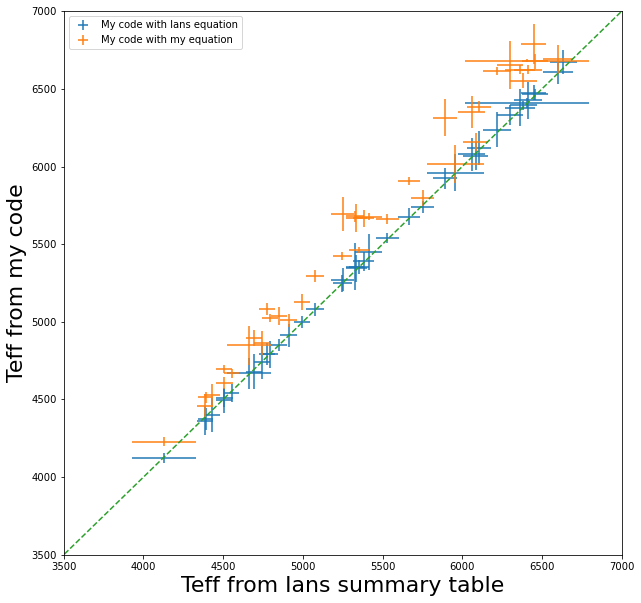

In [554]:
f = plt.figure(figsize=[10,10])
plt.errorbar(df_ian_sum['Teff'],df_ian_ianeq['teff_loop0'],xerr=df_ian_sum['e_teff'],yerr=df_ian_ianeq['e_teff_loop0'],ls='none',label='My code with Ian''s equation')
plt.errorbar(df_ian_sum['Teff'],df_ian_myeq['teff_loop0'],xerr=df_ian_sum['e_teff'],yerr=df_ian_myeq['e_teff_loop0'],ls='none',label='My code with my equation')
plt.xlabel('Teff from Ian''s summary table',fontsize=22)
plt.ylabel('Teff from my code',fontsize=22)
plt.legend()
plt.plot([3000,8000],[3000,8000],ls='--')
plt.xlim([3500,7000])
plt.ylim([3500,7000])
plt.show()
f.savefig('teff_logg/teff_compare.pdf')

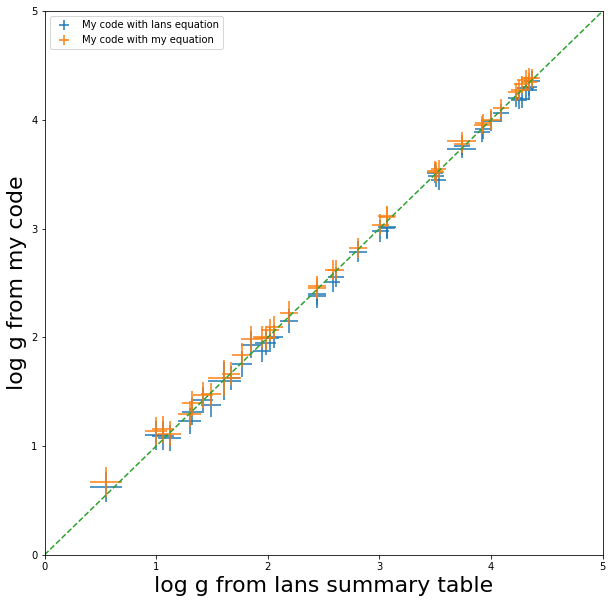

In [555]:
f = plt.figure(figsize=[10,10])
plt.errorbar(df_ian_sum['logg'],df_ian_ianeq['logg_loop0'],xerr=df_ian_sum['e_logg'],yerr=df_ian_ianeq['e_logg_loop0'],ls='none',label='My code with Ian''s equation')
plt.errorbar(df_ian_sum['logg'],df_ian_myeq['logg_loop0'],xerr=df_ian_sum['e_logg'],yerr=df_ian_myeq['e_logg_loop0'],ls='none',label='My code with my equation')
plt.xlabel('log g from Ian''s summary table',fontsize=22)
plt.ylabel('log g from my code',fontsize=22)
plt.legend()
plt.plot([0,5],[0,5],ls='--')
plt.xlim([0,5])
plt.ylim([0,5])
plt.show()
f.savefig('teff_logg/logg_compare.pdf')